In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, shape)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import (running_mean_APWP, running_mean_APWP_shape, RM_stats, get_pseudo_vgps, get_vgps_sampling_direction, 
                                  running_mean_VGPs_bootstrapped, running_mean_bootstrapping_direction)

from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble, quantiles, PC
np.random.seed(1)

## Compiles a DataFrame for both, the VGPs and the recomputed poles by study

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [3]:
df_filtered_vgps, df_pole_compilation = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True) # takes as many as poles as are described for one are

## Set the hyperparameters for further comparissons.

In [4]:
min_age = 0
max_age = 65
window_length = 15
time_step = 5
# define a list to store all the models
models = []

### 1. Running means classic approach on poles

In [5]:
RM_1_classic_by_study = running_mean_APWP (df_pole_compilation, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_1_classic_by_study['method'] = "RM_classic"
models.append(RM_1_classic_by_study)
RM_1_classic_by_study.head(5)

,age,N,n_studies,k,A95,csd,plon,plat,method
0,0.0,12.0,12.0,135.172992,3.746692,6.966908,-77.850084,-86.746017,RM_classic
1,5.0,15.0,15.0,157.806367,3.053286,6.447966,-67.163587,-87.015353,RM_classic
2,10.0,6.0,6.0,227.312026,4.453474,5.372468,-79.156412,-88.237442,RM_classic
3,15.0,4.0,4.0,634.387048,3.650730,3.215939,-21.810052,-86.038002,RM_classic
4,20.0,3.0,3.0,614.606390,4.976959,3.267281,-18.481366,-82.522049,RM_classic


### 2. Running means ensemble from pseudo-VGPs approach (Vaes et al. 2022)

In [6]:
%%time
RM_2_ensemble_pseudoVGP = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):   
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation)
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP_shape(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i

    RM_2_ensemble_pseudoVGP = RM_2_ensemble_pseudoVGP.append(RM_APWP_parametric_temp, ignore_index=True)
RM_2_ensemble_pseudoVGP['plon'] = RM_2_ensemble_pseudoVGP.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)    
RM_2_ensemble_pseudoVGP['method'] = "RM_pseudoVGPs_ensemble"
models.append(RM_2_ensemble_pseudoVGP)

CPU times: user 25.2 s, sys: 124 ms, total: 25.3 s
Wall time: 25.3 s


Set quantiles

In [7]:
RM_2_quantiles_plat = quantiles(RM_2_ensemble_pseudoVGP,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_2_quantiles_plon = quantiles(RM_2_ensemble_pseudoVGP,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_2_ensemble_pseudoVGP.head(3)

,run,n_studies,k,A95,csd,age,N,plon,plat,foliation,lineation,collinearity,coplanarity,method
0,0,15.0,23.940365,1.754527,16.554636,0.0,280.0,-49.762211,-86.962600,0.120930,0.810995,6.706304,0.931926,RM_pseudoVGPs_ensemble
1,0,15.0,23.985074,1.618864,16.5392,5.0,328.0,-48.759449,-87.269952,0.095148,0.789994,8.302781,0.885142,RM_pseudoVGPs_ensemble
2,0,10.0,21.688459,2.257668,17.392847,10.0,188.0,-66.892796,-87.917587,0.147098,0.681468,4.632757,0.828566,RM_pseudoVGPs_ensemble


## 3. Running means on VGPs. 
Three different approachs as follows:
### 3.1. Running means on the computed dataset (one run and A95)

In [8]:
RM_31_on_VGP = running_mean_APWP(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age)
RM_31_on_VGP['method'] = "RM_classic_VGPs"
models.append(RM_31_on_VGP)

In [9]:
RM_31_on_VGP.head(3)

,age,N,n_studies,k,A95,csd,plon,plat,method
0,0.0,283.0,15.0,23.737437,1.752923,16.625247,-45.869508,-88.098726,RM_classic_VGPs
1,5.0,308.0,15.0,22.847346,1.713794,16.945998,-45.430085,-88.076649,RM_classic_VGPs
2,10.0,161.0,9.0,20.924372,2.487633,17.707563,-46.191588,-87.489859,RM_classic_VGPs


### 3.2. Running means on random samples (with replacement) from the original dataset to generate an ensemble of possible solution.

In [10]:
%%time
RM_32_boots_VGPs=running_mean_VGPs_bootstrapped(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age, n_bst = 100)
RM_32_boots_VGPs['method']="RM_bootstrapped_VGPs_ensemble"
models.append(RM_32_boots_VGPs)

CPU times: user 10.8 s, sys: 88.1 ms, total: 10.8 s
Wall time: 10.9 s


Set quantiles

In [11]:
RM_32_quantiles_plat = quantiles(RM_32_boots_VGPs,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_32_quantiles_plon = quantiles(RM_32_boots_VGPs,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_32_boots_VGPs.head(3)

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
0,0.0,289.0,24.001905,1.724536,16.5334,0.164651,0.701692,4.261689,0.866343,0.0,15.0,-29.498420,-87.091687,RM_bootstrapped_VGPs_ensemble
1,0.0,329.0,21.895409,1.695284,17.310455,0.142403,0.655401,4.602424,0.797805,5.0,15.0,-22.696254,-87.272722,RM_bootstrapped_VGPs_ensemble
2,0.0,181.0,21.243465,2.326417,17.574069,0.145077,0.782163,5.391363,0.92724,10.0,9.0,-17.422625,-86.865561,RM_bootstrapped_VGPs_ensemble


### 3.3. Propation of directional error towards the VGP level. 
We take the original directions as a PDF to generate to generate a pseudo-Dataset that incorporates the uncertinty in the directional space and time. We aaply the running means on a number of $pseudo$-VGPs to generate an ensemble of possible paths

In [12]:
%%time
RM_33_propagation=running_mean_bootstrapping_direction(df_filtered_vgps,'plon', 'plat', 'age', window_length, time_step, max_age, min_age, n_bst = 100)
RM_33_propagation['method']="RM_DirErrorPropagated_ensemble"
models.append(RM_33_propagation)

CPU times: user 42 s, sys: 176 ms, total: 42.2 s
Wall time: 42.2 s


Set quantiles

In [13]:
RM_33_quantiles_plat = quantiles(RM_33_propagation,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_33_quantiles_plon = quantiles(RM_33_propagation,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_33_propagation.head(3)

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
0,0.0,278.0,19.378865,1.967259,18.400128,0.063724,0.603386,9.468712,0.66711,0.0,15.0,-71.455981,-88.685595,RM_DirErrorPropagated_ensemble
1,0.0,291.0,19.68846,1.906595,18.254887,0.038787,0.620924,16.008752,0.65971,5.0,15.0,-70.237272,-88.712996,RM_DirErrorPropagated_ensemble
2,0.0,118.0,12.853794,3.773364,22.592764,0.249205,0.527671,2.117417,0.776877,10.0,9.0,-35.168259,-87.359963,RM_DirErrorPropagated_ensemble


## Get APW from Muller et al., 2016 and Torsvik and Cocks, 2017

- Müller, R. D., Seton, M., Zahirovic, S., Williams, S. E., Matthews, K. J., Wright, N. M., ... & Cannon, J. (2016). Ocean basin evolution and global-scale plate reorganization events since Pangea breakup. Annual Review of Earth and Planetary Sciences, 44, 107-138. DOI:10.1146/annurev-earth-060115-012211
- Torsvik, T. H., & Cocks, L. R. M. (2013). Gondwana from top to base in space and time. Gondwana Research, 24(3-4), 999-1030.


In [14]:
Torsvik2017_path = np.loadtxt('model_APWP/code_output/NAM_0_60_torsvik_2017.txt', )
Torsvik2017_path_df = pd.DataFrame(Torsvik2017_path, columns = ['age','plon', 'plat', 'Euler_angle', 'Euler_lon', 'Euler_lat'])
Torsvik2017_path_df = Torsvik2017_path_df[Torsvik2017_path_df['age']>0]
Torsvik2017_path_df['method'] = "plate model"
models.append(Torsvik2017_path_df)

Mueller2016_path = np.loadtxt('model_APWP/code_output/NAM_0_60_muller_2016.txt', )
Mueller2016_path_df = pd.DataFrame(Mueller2016_path, columns = ['age','plon', 'plat', 'Euler_angle', 'Euler_lon', 'Euler_lat'])
Mueller2016_path_df = Mueller2016_path_df[Mueller2016_path_df['age']>0]
Mueller2016_path_df['method']="plate model"
models.append(Mueller2016_path_df)

Merge

In [15]:
df_all = pd.concat(models, axis=0)
df_all.head()

,age,N,n_studies,k,A95,csd,plon,plat,method,run,foliation,lineation,collinearity,coplanarity,Euler_angle,Euler_lon,Euler_lat
0,0.0,12.0,12.0,135.172992,3.746692,6.966908,-77.850084,-86.746017,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,15.0,15.0,157.806367,3.053286,6.447966,-67.163587,-87.015353,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,6.0,6.0,227.312026,4.453474,5.372468,-79.156412,-88.237442,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15.0,4.0,4.0,634.387048,3.65073,3.215939,-21.810052,-86.038002,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20.0,3.0,3.0,614.60639,4.976959,3.267281,-18.481366,-82.522049,RM_classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Comparisons plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


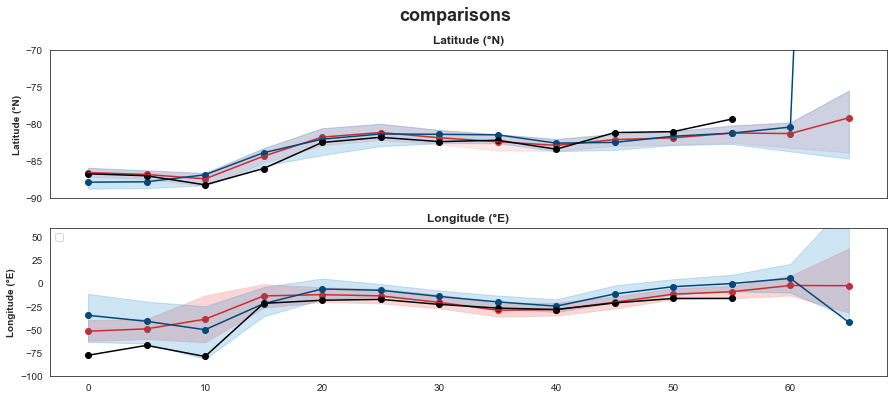

In [35]:
title = "comparisons"

df_method1=RM_2_ensemble_pseudoVGP
df_method2=RM_33_propagation

ensemble1_lat = quantiles(df_method1,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
ensemble1_lon = quantiles(df_method1,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
ensemble2_lat = quantiles(df_method2,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
ensemble2_lon = quantiles(df_method2,"age","plon") # set quantiles of longitude groupedby age for visualization purposes

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')

axes[0].set_ylim(-90,-70)
axes[1].set_ylim(-100,60)
# LATITUDE
axes[0].fill_between(ensemble1_lat.X, ensemble1_lat.q16,ensemble1_lat.q84, color= "#f98787", alpha=.20)
axes[0].scatter(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[1],color="#d12a2a")
axes[0].plot(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[1],color="#d12a2a")

axes[0].fill_between(ensemble2_lat.X, ensemble2_lat.q16,ensemble1_lat.q84, color= "#0E7DC9", alpha=.20)
axes[0].scatter(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[1],color="#00497A")
axes[0].plot(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[1],color="#00497A")

axes[0].plot(RM_1_classic_by_study.age, RM_1_classic_by_study.plat, '-',color="black") #CLASSIC
axes[0].scatter(RM_1_classic_by_study.age, RM_1_classic_by_study.plat, color="black") #CLASSIC


# # LONGITUDE
axes[1].fill_between(ensemble1_lon.X, ensemble1_lon.q16,ensemble1_lon.q84, color= "#f9afaf", alpha=.50,label="0.16-0.84 percentiles - Ensemble 1")
axes[1].plot(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[0], '-',color="#d12a2a")
axes[1].scatter(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[0],color="#d12a2a")

axes[1].fill_between(ensemble2_lon.X, ensemble2_lon.q16,ensemble2_lon.q84, color= "#0E7DC9", alpha=.20,label="0.16-0.84 percentiles - Ensemble 2")
axes[1].plot(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[0], '-',color="#00497A")
axes[1].scatter(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[0],color="#00497A")
axes[1].plot(RM_1_classic_by_study.age, RM_1_classic_by_study.plon, '-',color="black", label = "RM classic") #CLASSIC
axes[1].scatter(RM_1_classic_by_study.age, RM_1_classic_by_study.plon, color="black") #CLASSIC

plt.legend(loc="upper left")

In [17]:
PC(df_method2,"age","plat","plon").PC()[0]

array([-34.69917627950082 , -41.17022363446277 , -50.27159004846883 ,
       -22.146749302424762,  -6.300843519219139,  -7.699628190197703,
       -14.374288602366663, -20.260814943274063, -24.806260416402207,
       -11.641959159266777,  -3.819232450035336,  -0.428470728612749,
         5.13740341764271 , -42.25861832170029 ])

In [38]:
PC(df_method1,"age","plat","plon").PC()[0]

array([-49.702357350916095, -48.59556133174454 , -34.41204762528058 ,
       -15.026769398840683, -13.069829820946882, -14.948016092187274,
       -21.358617532783263, -29.441753099930704, -27.761680564075476,
       -20.243744784102876, -10.845642310156673,  -7.814260266558612,
         0.411560284456102,   8.972190620871139])

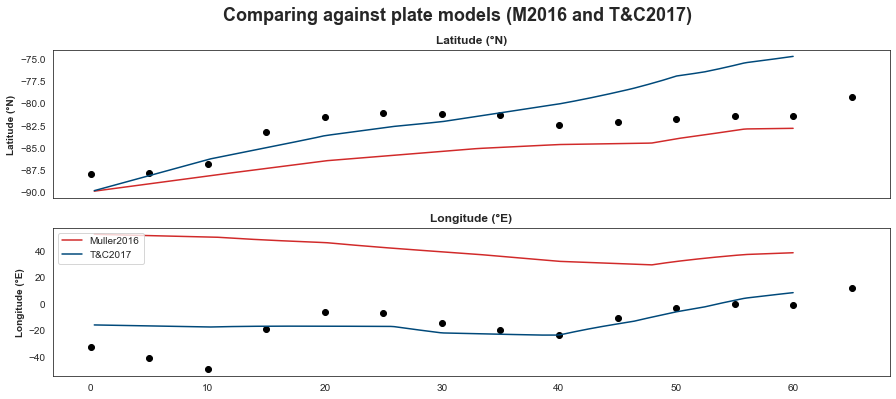

In [17]:
title = "Comparing against plate models (M2016 and T&C2017)"

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')
# LATITUDE

axes[0].plot(Mueller2016_path_df.age, Mueller2016_path_df.plat, '-',color="#d12a2a")
# axes[0].scatter(Mueller2016_path_df.age, Mueller2016_path_df.plat,s = 1, color="#d12a2a")
axes[0].plot(Torsvik2017_path_df.age, Torsvik2017_path_df.plat, '-',color="#00497A") #CLASSIC
# axes[0].scatter(Torsvik2017_path_df.age, Torsvik2017_path_df.plat, color="#00497A") #CLASSIC
axes[0].scatter(ensemble2_lat.X, ensemble2_lat.q50,color="black")
# LONGITUDE

axes[1].plot(Mueller2016_path_df.age, Mueller2016_path_df.plon, '-',color="#d12a2a", label = "Muller2016")
# axes[1].scatter(Mueller2016_path_df.age, Mueller2016_path_df.plon,color="#d12a2a")
axes[1].plot(Torsvik2017_path_df.age, Torsvik2017_path_df.plon, '-',color="#00497A", label = "T&C2017") #CLASSIC
# axes[1].scatter(Torsvik2017_path_df.age, Torsvik2017_path_df.plon, color="#00497A") #CLASSIC
axes[1].scatter(ensemble2_lon.X, ensemble2_lon.q50,color="black")

# axes[1].set_ylim(-100, 50)
plt.legend(loc="upper left")

In [20]:
PC(RM_33_propagation,"age","plat","plon").PC()[1]

array([-87.83846485397872, -87.71634299055385, -86.56234875787946,
       -83.01984980423997, -81.51742520573396, -81.0594192697066 ,
       -81.31920288056929, -81.43132005870639, -82.38016524796765,
       -82.21984526600528, -81.73369936557516,  98.58164723908982,
       -81.17753572794868, 100.8233441701707 ])

In [20]:
RM_33_propagation
RM_32_boots_VGPs

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
0,0.0,291.0,23.109803,1.752895,16.849495,0.177638,0.718905,4.047023,0.896543,0.0,14.0,-54.934468,-87.609392,RM_bootstrapped_VGPs_ensemble
1,0.0,309.0,22.827044,1.711801,16.953532,0.185288,0.697438,3.764073,0.882726,5.0,14.0,-52.950440,-87.724472,RM_bootstrapped_VGPs_ensemble
2,0.0,159.0,20.444298,2.534087,17.914262,0.317275,0.656406,2.06889,0.973681,10.0,9.0,-58.550039,-88.768761,RM_bootstrapped_VGPs_ensemble
3,0.0,63.0,14.973783,4.783091,20.932411,0.305627,0.340017,1.11252,0.645644,15.0,7.0,-25.077597,-83.128644,RM_bootstrapped_VGPs_ensemble
4,0.0,133.0,10.14031,4.044485,25.43662,0.23203,0.474333,2.044277,0.706363,20.0,7.0,-14.805770,-82.273687,RM_bootstrapped_VGPs_ensemble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,99.0,291.0,18.234489,1.985383,18.968728,0.198377,0.435742,2.196537,0.634118,45.0,10.0,-16.130575,-81.572386,RM_bootstrapped_VGPs_ensemble
1396,99.0,255.0,16.902633,2.208715,19.701887,0.127609,0.37349,2.926837,0.501099,50.0,8.0,-13.953657,-80.667848,RM_bootstrapped_VGPs_ensemble
1397,99.0,215.0,17.012987,2.398413,19.637886,0.0539,0.455666,8.453921,0.509566,55.0,5.0,-13.591928,-79.590728,RM_bootstrapped_VGPs_ensemble
1398,99.0,45.0,13.921925,5.913888,21.708777,0.403687,0.186248,0.461367,0.589935,60.0,2.0,-5.495404,-77.852251,RM_bootstrapped_VGPs_ensemble


In [23]:
plott = RM_32_boots_VGPs[RM_32_boots_VGPs['age']==15]
plott

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
3,0.0,63.0,14.973783,4.783091,20.932411,0.305627,0.340017,1.11252,0.645644,15.0,7.0,-25.077597,-83.128644,RM_bootstrapped_VGPs_ensemble
17,1.0,88.0,18.006964,3.656052,19.088191,0.50752,0.178833,0.352366,0.686352,15.0,7.0,-1.275297,-82.239618,RM_bootstrapped_VGPs_ensemble
31,2.0,66.0,17.646747,4.279362,19.282027,0.126139,0.211363,1.675638,0.337501,15.0,7.0,1.775168,-84.505998,RM_bootstrapped_VGPs_ensemble
45,3.0,69.0,17.479895,4.20431,19.373836,0.236266,0.040073,0.169609,0.276338,15.0,6.0,-16.013627,-82.398977,RM_bootstrapped_VGPs_ensemble
59,4.0,75.0,18.18748,3.9453,18.993227,0.579397,0.270563,0.466974,0.849959,15.0,7.0,-14.788076,-85.972911,RM_bootstrapped_VGPs_ensemble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,95.0,62.0,17.036322,4.501821,19.624432,0.173539,0.358117,2.06361,0.531656,15.0,6.0,-3.853168,-85.182861,RM_bootstrapped_VGPs_ensemble
1347,96.0,80.0,14.820211,4.257166,21.040586,0.382388,0.573978,1.501037,0.956366,15.0,7.0,6.646190,-85.380243,RM_bootstrapped_VGPs_ensemble
1361,97.0,74.0,17.235958,4.087112,19.510451,0.270327,0.261069,0.965752,0.531397,15.0,7.0,2.851489,-84.272550,RM_bootstrapped_VGPs_ensemble
1375,98.0,73.0,22.010345,3.618052,17.265199,0.414851,0.094679,0.228224,0.50953,15.0,6.0,-18.564801,-80.007090,RM_bootstrapped_VGPs_ensemble


In [24]:
array = np.array([spherical2cartesian([ np.radians(i['plon']),np.radians(i['plat'])]) for _,i in plott.iterrows()])
eigenValues, eigenVectors = eigen_decomposition(array)
print(np.degrees(cartesian2spherical(eigenVectors[:,0])),len(array))

[-14.546738466253293 -83.2370179747668  ] 100


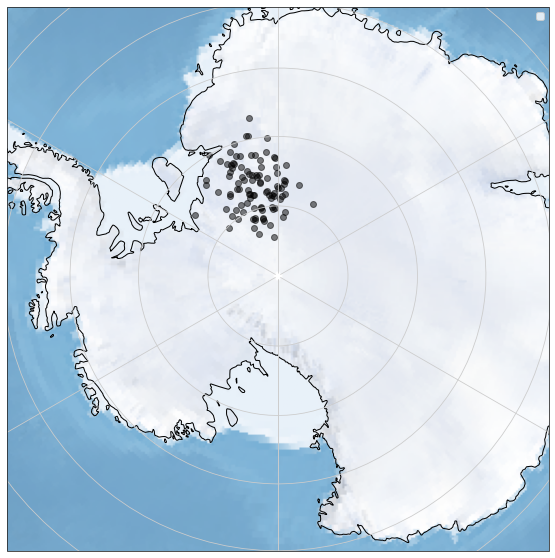

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
from shapely.geometry import Polygon

extent = [-180,180,-70,-70]
fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# sns.scatterplot(x = RM_ensembl_quant_plon.mean, y =RM_ensemble_quant_plat.mean,
                
#                 transform = ccrs.PlateCarree())
plt.scatter(plott.plon, plott.plat,transform = ccrs.Geodetic(), color = "black", alpha = 0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()